In [21]:
import sys
sys.path.insert(0,'C:\\users\\alexa\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime
from scipy import stats
from scipy.optimize import minimize
from scipy import optimize
from scipy.stats import entropy

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, Tuple

"""
Own packages
"""
from codelib.portfolio_optimization.mean_variance import portfolio_mean, portfolio_std, portfolio_variance
from codelib.statistics import calculate_cornish_fisher_percentile
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_std
from codelib.portfolio_optimization.risk_metrics import calculate_normal_cond_value_at_risk, calculate_normal_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_normal_port_cond_value_at_risk, calculate_normal_port_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_conditional_value_at_risk, calculate_value_at_risk
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_cvar, calculate_risk_contributions_cvar

from codelib.portfolio_optimization.risk_metrics import drawdown, maxdrawdown

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix
from codelib.statistics.robust_covariance import marchencko_pastur_bounds, marchencko_pastur_density, fitting_error, crem_denoised_corr_mat

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
reader = FamaFrenchReader("49_Industry_Portfolios", start=datetime.datetime(1970, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

'49 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202210 CRSP database. It contains value- and equal-weighted returns for 49 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2022 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (634 rows x 49 cols)\n  1 : Average Equal Weighted Returns -- Monthly (634 rows x 49 cols)\n  2 : Average Value Weighted Returns -- Annual (52 rows x 49 cols)\n  3 : Average Equal Weighted Returns -- Annual (52 rows x 49 cols)\n  4 : Number of Firms in Portfolios (634 rows x 49 cols)\n  5 : Average Firm Size (634 rows x 49 cols)\n  6 : Sum of BE / Sum of ME (53 rows x 49 cols)\n  7 : Value-Weighted Average of BE/ME (53 rows x 49 cols)'

In [4]:
# get equally weighted
ind_eq_weighted = industry_port[1] / 100
ind_eq_weighted.columns = ind_eq_weighted.columns.str.strip()
#ind_eq_weighted.index = pd.to_datetime(ind_eq_weighted.index, format="%Y-%m")

# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100
ind_mc_weighted.columns = ind_mc_weighted.columns.str.strip()
#ind_mc_weighted.index = pd.to_datetime(ind_mc_weighted.index, format="%Y%m")

# get number of companies in each sector
num_companies = industry_port[4]
num_companies.columns = num_companies.columns.str.strip()
#num_companies.index = pd.to_datetime(num_companies.index, format="%Y%m")

# get average firm size 
avg_firm_size = industry_port[5]
avg_firm_size.columns = avg_firm_size.columns.str.strip()
#avg_firm_size.index = pd.to_datetime(avg_firm_size.index, format="%Y%m")

# get sector market cap 
sector_mkt_cap  = num_companies * avg_firm_size
total_mkt_cap = sector_mkt_cap.sum(axis=1)

# get relative market cap
sector_mkt_cap_relative = sector_mkt_cap.divide(total_mkt_cap, axis="rows")

# calculate market return 
market_return = (sector_mkt_cap_relative * ind_mc_weighted).sum(axis="columns")

# calculate equal weighted return 
equal_weighted_return = (ind_mc_weighted / 12.0).sum(axis="columns")

# asset list
asset_list = ind_mc_weighted.columns

#Weights
w_mc = sector_mkt_cap.divide(total_mkt_cap, axis ="rows")

#Define equally weight portfolio weights
w_eq = weights = np.repeat(1.0 / 49.0, 49)

In [5]:
mkt_index = (1 + market_return).cumprod()
eq_index = (1 + equal_weighted_return).cumprod()

In [6]:
"""
Calculate log returns
"""

log_returns = np.log(1+ind_mc_weighted)

In [7]:
mean_log_returns = log_returns.mean()
mean_log_returns

Agric    0.008092
Food     0.009685
Soda     0.008940
Beer     0.009792
Smoke    0.011593
Toys     0.004519
Fun      0.009368
Books    0.006687
Hshld    0.007319
Clths    0.008295
Hlth     0.006134
MedEq    0.008605
Drugs    0.009351
Chems    0.008435
Rubbr    0.008502
Txtls    0.006198
BldMt    0.008080
Cnstr    0.006776
Steel    0.005023
FabPr    0.005651
Mach     0.008190
ElcEq    0.009075
Autos    0.007570
Aero     0.009460
Ships    0.007958
Guns     0.011125
Gold     0.003544
Mines    0.007399
Coal     0.004750
Oil      0.009069
Util     0.008178
Telcm    0.007788
PerSv    0.003901
BusSv    0.007748
Hardw    0.006456
Softw    0.005245
Chips    0.008594
LabEq    0.008296
Paper    0.007237
Boxes    0.007854
Trans    0.007955
Whlsl    0.008170
Rtail    0.009162
Meals    0.008727
Banks    0.007823
Insur    0.009364
RlEst    0.003264
Fin      0.009149
Other    0.002977
dtype: float64

In [8]:
cov_mat_log_returns = log_returns.cov()
cov_mat_log_returns

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Agric,0.004128,0.001367,0.001391,0.001441,0.001369,0.002351,0.002596,0.002154,0.001333,0.002202,...,0.001907,0.002170,0.002201,0.001803,0.002188,0.002059,0.001827,0.002657,0.002356,0.002291
Food,0.001367,0.001982,0.001667,0.001608,0.001637,0.001768,0.001904,0.001682,0.001441,0.001839,...,0.001487,0.001570,0.001609,0.001658,0.001810,0.001697,0.001694,0.001834,0.001555,0.001694
Soda,0.001391,0.001667,0.004108,0.002102,0.001658,0.002187,0.002597,0.002091,0.001930,0.002254,...,0.001942,0.001936,0.001972,0.001913,0.002292,0.002187,0.002010,0.002508,0.002066,0.002053
Beer,0.001441,0.001608,0.002102,0.002683,0.001483,0.002014,0.002134,0.001718,0.001780,0.001895,...,0.001597,0.001766,0.001715,0.001763,0.002076,0.001827,0.001719,0.002014,0.001756,0.001955
Smoke,0.001369,0.001637,0.001658,0.001483,0.003896,0.001728,0.001744,0.001476,0.001437,0.001557,...,0.001483,0.001402,0.001631,0.001331,0.001627,0.001620,0.001462,0.001709,0.001437,0.001791
Toys,0.002351,0.001768,0.002187,0.002014,0.001728,0.005590,0.004143,0.003048,0.002197,0.003531,...,0.002726,0.003200,0.003018,0.002883,0.003347,0.002840,0.002489,0.003832,0.003104,0.003110
Fun,0.002596,0.001904,0.002597,0.002134,0.001744,0.004143,0.006380,0.003550,0.002300,0.003797,...,0.002896,0.003284,0.003348,0.003141,0.003648,0.003303,0.002819,0.004383,0.003714,0.003510
Books,0.002154,0.001682,0.002091,0.001718,0.001476,0.003048,0.003550,0.003702,0.001900,0.003048,...,0.002334,0.002702,0.002717,0.002559,0.002718,0.002786,0.002459,0.003625,0.002952,0.002796
Hshld,0.001333,0.001441,0.001930,0.001780,0.001437,0.002197,0.002300,0.001900,0.002208,0.001998,...,0.001781,0.001886,0.001788,0.001816,0.002108,0.001897,0.001724,0.002041,0.001856,0.002024
Clths,0.002202,0.001839,0.002254,0.001895,0.001557,0.003531,0.003797,0.003048,0.001998,0.004560,...,0.002505,0.002998,0.002876,0.003053,0.003152,0.002890,0.002511,0.003807,0.003032,0.003033


In [9]:
corr_mat_log_returns = cov_to_corr_matrix(cov_mat_log_returns)

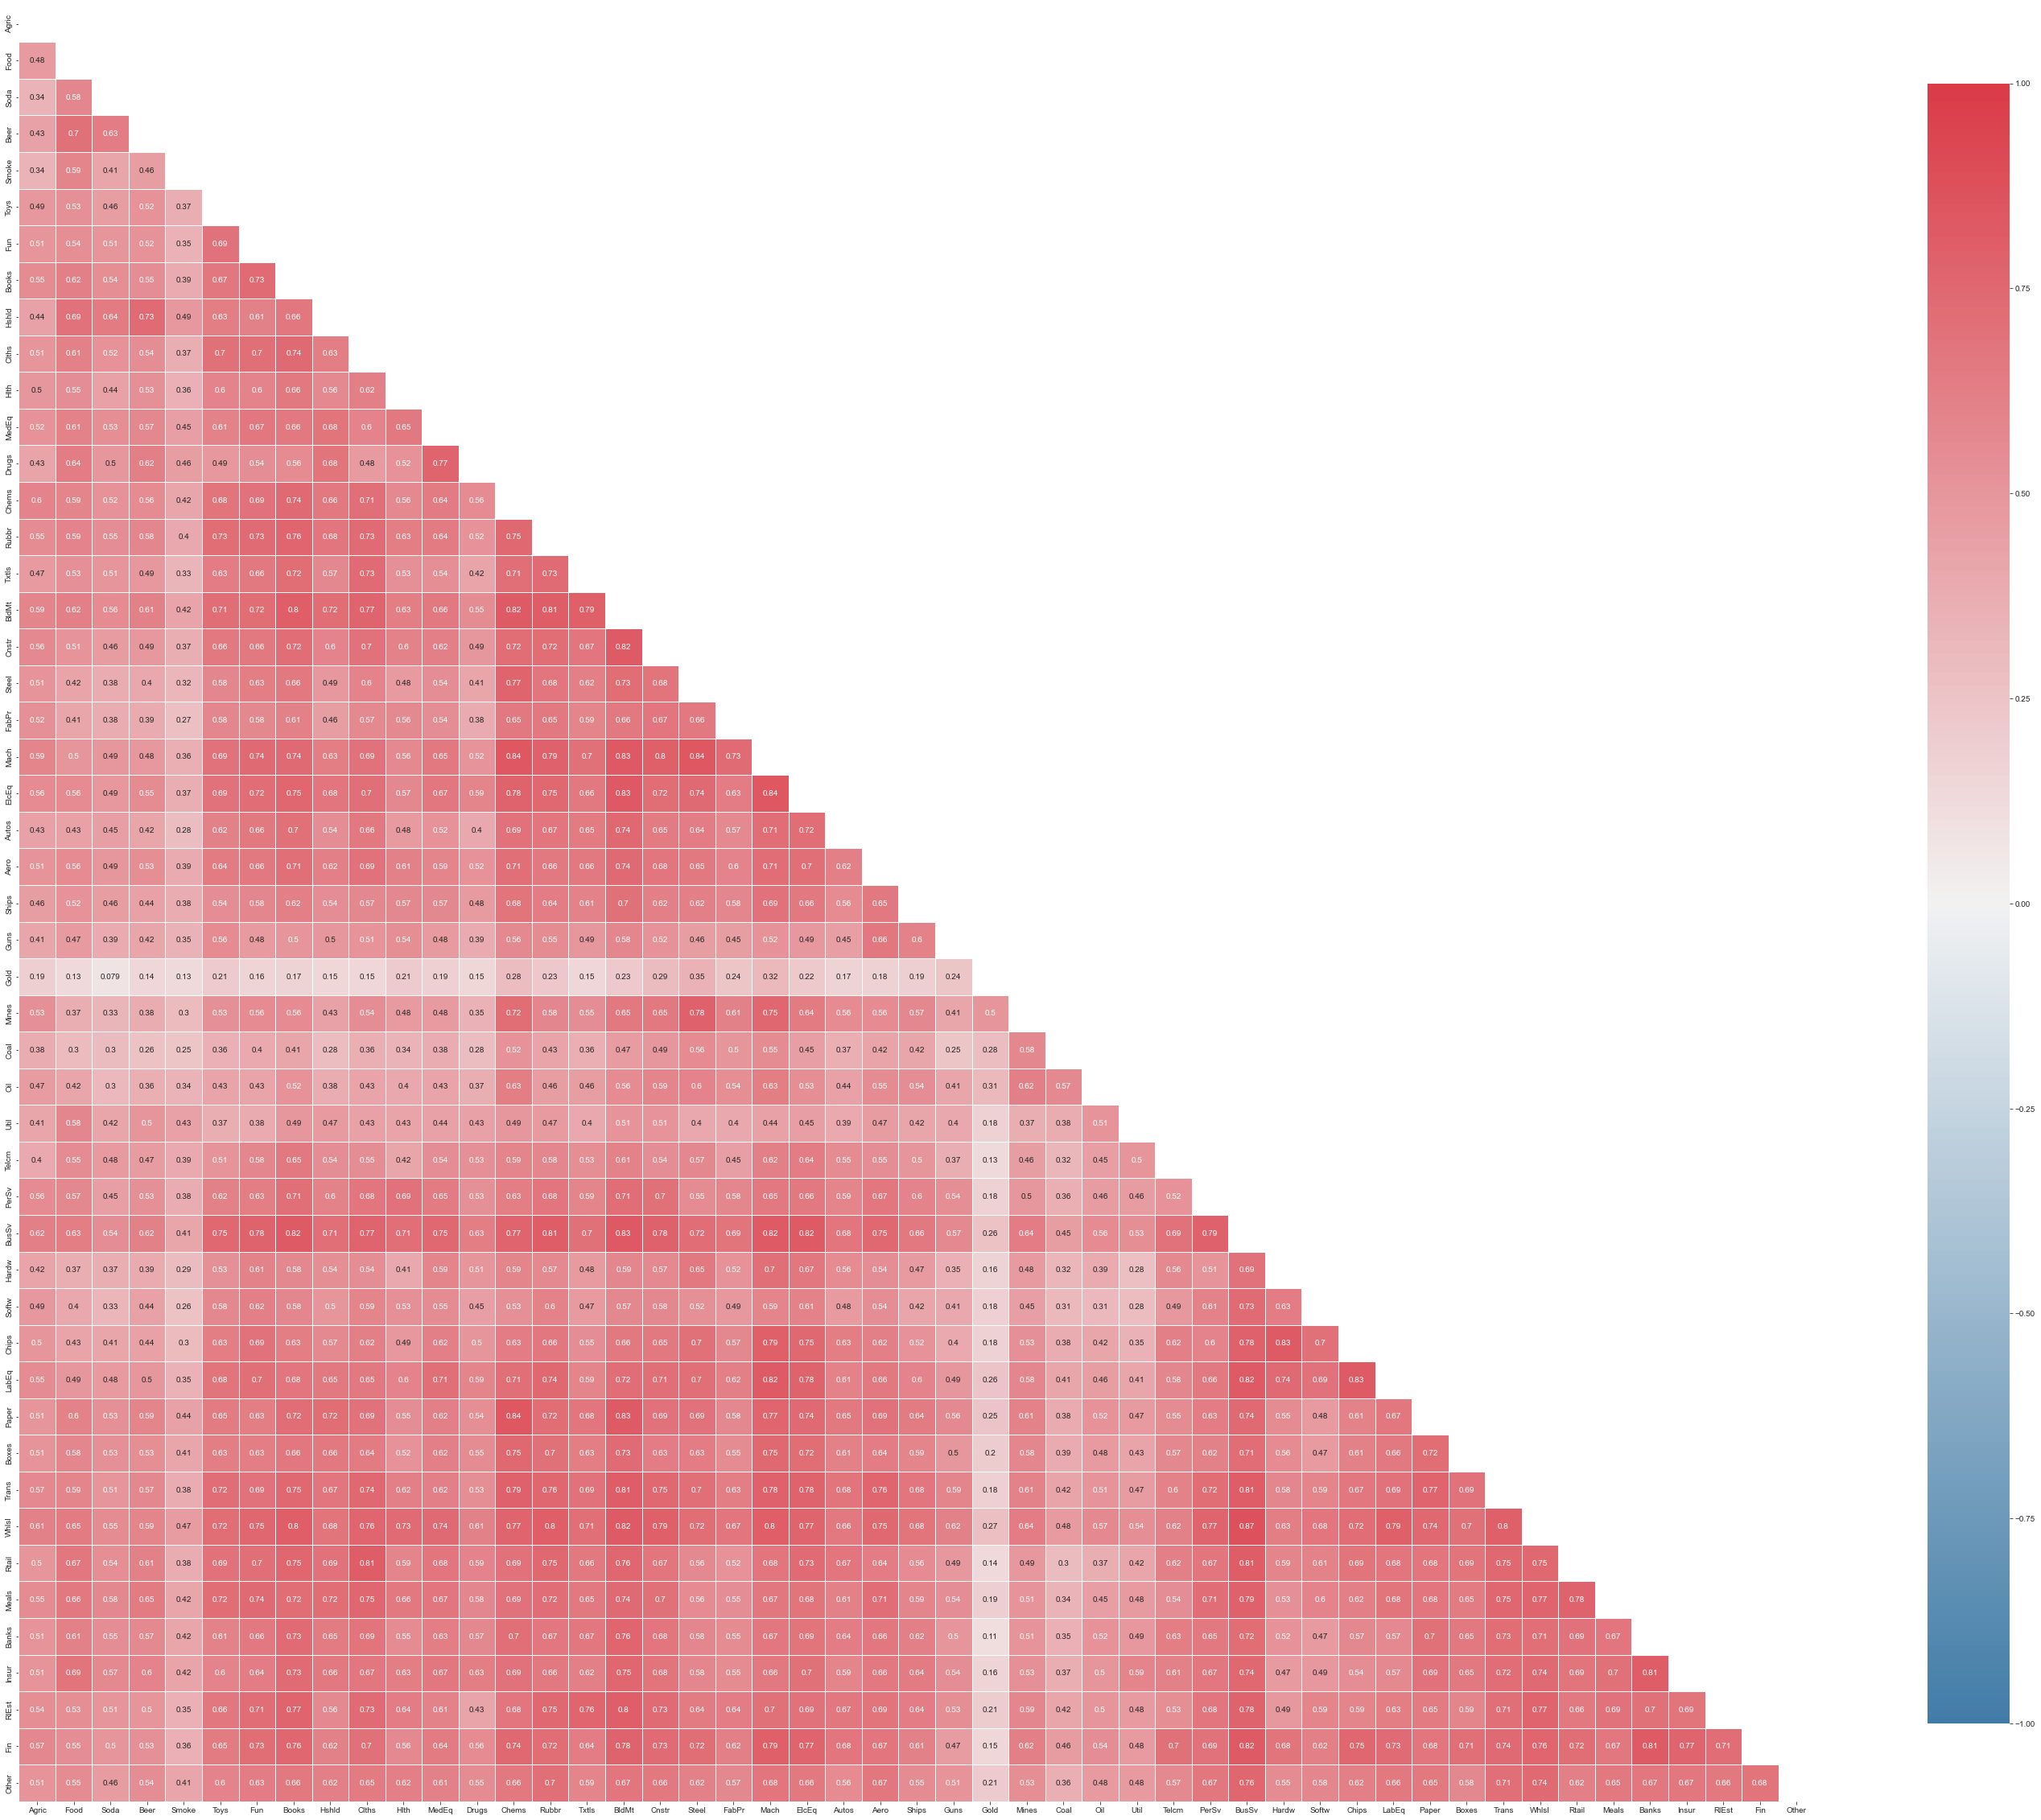

In [10]:
fig, ax = plt.subplots(figsize=(50, 50))
correlation_plot(corr_mat_log_returns, names=asset_list, include_values=True, ax=ax)

In [29]:
start = datetime.datetime(1970,1,1)
end = datetime.datetime(2022,11,1)
dates = pd.date_range(start,end-datetime.timedelta(days=1),freq='m')

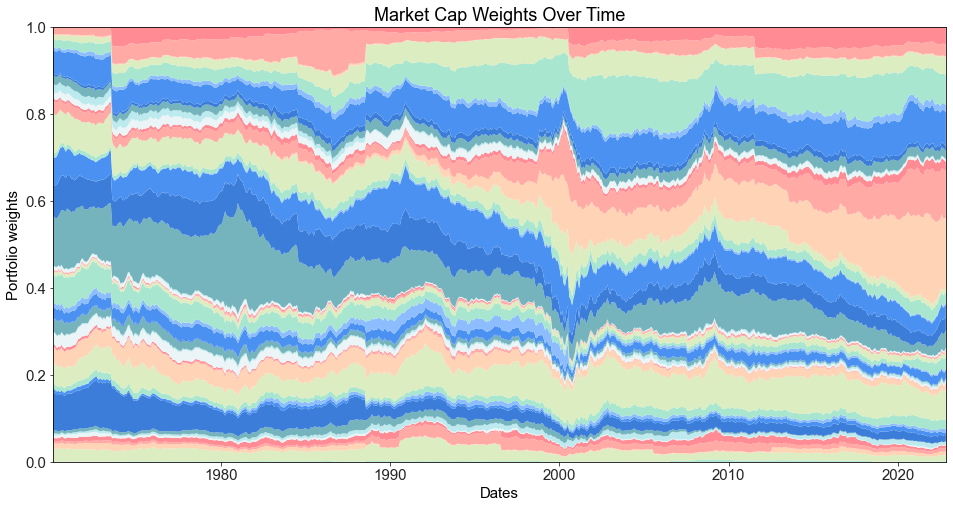

In [32]:
fig, ax = plt.subplots(figsize=(16, 8))


ax.stackplot(dates, w_mc.T);
ax.set_xlabel("Dates")
ax.set_ylabel("Portfolio weights")
ax.set_title("Market Cap Weights Over Time");

In [13]:
import numpy as np
def calculate_enc(weights: np.ndarray, alpha: int = 1, relative: bool = False) -> float:

    """
    Calculates the effective number of constituents in a long-only portfolio.

    if :math:`\\alpha>0, \\alpha \\neq 1`, then

    .. math::

        \\begin{equation}
            \\text{ENC}(w, \\alpha) = \\Vert w \\Vert_{\\alpha}^{\\frac{\\alpha}{1- \\alpha}}
        \\end{equation}

    Note that :math:`\\alpha = 2` will correspond to the inverse of the Herfindahl index.

    if :math:`\\alpha = 1` then the exponential of the entropy of the portfolio weights

    .. math::

        \\begin{equation}
            \\text{ENC}(w, \\alpha) = \\exp \\left(- \\sum_{i=1}^N w_i \\ln w_i \\right)
        \\end{equation}

    Parameters
    ----------
    weights:
        Portfolio weights.
    alpha:
        Alpha parameter.
    relative:
        Calculate diversification relative to number of assets. Default is False.

    Returns
    -------

    """

    num_constituents = len(weights)
    enc = 0.0

    if alpha <= 0:
        raise ValueError("Alpha must be larger than zero.")
    elif alpha == 1:
        enc = np.exp(entropy(weights))
    else:
        norm = np.linalg.norm(weights, ord=alpha)
        enc = norm**(alpha / (1 - alpha))

    if relative:
        return enc / num_constituents
    else:
        return enc

In [14]:
calculate_enc(sector_mkt_cap_relative, 1)

array([522.30136081, 593.2608445 , 468.05077864, 524.98843141,
       592.93344235, 531.47937272, 584.42892418, 486.39692099,
       533.3637414 , 608.23011373, 545.10135777, 610.42366413,
       606.74360435, 579.21116894, 550.41274936, 482.960992  ,
       529.61170257, 603.89074893, 511.44038816, 483.0253319 ,
       614.99785631, 501.88965736, 519.47149185, 608.78209035,
       543.53734794, 579.0109019 , 540.57575874, 523.81761493,
       445.351262  , 566.17800693, 590.99185284, 614.68018549,
       586.48805324, 598.33790751, 573.2295003 , 352.73954653,
       552.43254529, 584.02478372, 597.17944685, 420.13897207,
       623.15515687, 612.36749092, 619.76907819, 608.39081984,
       554.66802146, 585.92244134, 565.22660227, 560.22513823,
       493.50336635])

In [15]:
def calculate_marginal_risks_std(weights: np.ndarray, cov_matrix: np.ndarray) -> np.ndarray:
    
    """
    Function that calculates marginal risk
    Parameters
    ----------
    weights: 
        Portfolio weights
    cov_matrix: 
        Covariance matrix
    
    Returns
    -------
    np.ndarray
        Marginal risks
    """
    
    total_risk = np.sqrt(weights @ cov_matrix @ weights)
    inner_derivative = cov_matrix @ weights
    
    return inner_derivative / total_risk

def calculate_risk_contributions_std(weights: np.ndarray, cov_matrix: np.ndarray, scale: bool = False) -> np.ndarray:
    
    """
    Function that calculates risk contributions
    
    Parameters
    ----------
    weights: 
        Portfolio weights
    cov_matrix: 
        Covariance matrix
    
    Returns
    -------
    np.ndarray
        Marginal risks
    """
    
    mr = calculate_marginal_risks_std(weights, cov_matrix)
    
    if scale: 
        mr /= np.sqrt(weights @ cov_matrix @ weights)
    
    return weights * mr

In [16]:
print("relative risk contribution: ")
rel_risk_contrib = calculate_risk_contributions_std(w_eq, cov_mat_log_returns, scale=True)
rel_risk_contrib

relative risk contribution: 


Agric    0.017156
Food     0.012509
Soda     0.015938
Beer     0.013891
Smoke    0.012471
Toys     0.023896
Fun      0.026396
Books    0.021077
Hshld    0.014532
Clths    0.022411
Hlth     0.023987
MedEq    0.016925
Drugs    0.013279
Chems    0.020534
Rubbr    0.021272
Txtls    0.024349
BldMt    0.023659
Cnstr    0.025388
Steel    0.026340
FabPr    0.022894
Mach     0.023784
ElcEq    0.023024
Autos    0.023501
Aero     0.023249
Ships    0.022511
Guns     0.016910
Gold     0.013231
Mines    0.023215
Coal     0.024917
Oil      0.016253
Util     0.009643
Telcm    0.013664
PerSv    0.021857
BusSv    0.021833
Hardw    0.020677
Softw    0.028302
Chips    0.024492
LabEq    0.023601
Paper    0.018712
Boxes    0.018449
Trans    0.020910
Whlsl    0.020678
Rtail    0.018472
Meals    0.020742
Banks    0.020224
Insur    0.018144
RlEst    0.025747
Fin      0.022241
Other    0.022116
dtype: float64

In [18]:
def calculate_glr_ratio(weights: np.ndarray, cov_mat: np.ndarray):

    """
    Calculates the diversification ratio of Goetzmann, Li, and Rouwenhorst (2005)

    .. math::

        \\begin{equation}
            \\text{GLR}(w, \\Sigma) = \\frac{w^{\\top} \\Sigma w}{\\sum_{i=1}^N w_i \\sigma_i^2}
        \\end{equation}

    Parameters
    ----------
    weights:
        Portfolio weights.
    cov_mat:
        Covariance matrix.

    Returns
    -------
    float
        Diversification ratio.

    """

    port_var = calculate_portfolio_variance(weights=weights, cov_mat=cov_mat)

    var_vec = np.diag(cov_mat)
    avg_var = np.inner(weights, var_vec)

    return port_var / avg_var

In [22]:
def calculate_diversification_measure(weights: np.ndarray, cov_mat: np.ndarray):
    
    
    port_vol = portfolio_std(weights=weights, cov_mat=cov_mat)
    avg_vol = np.inner(weights, port_vol)
    
    return avg_vol / port_vol
    

In [37]:
calculate_diversification_measure(w_eq, cov_mat_log_returns)

array([0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
       0.02040816, 0.02040816, 0.02040816, 0.02040816])

In [26]:
diversification_time = calculate_diversification_measure(w_eq, cov_mat_log_returns)